# Jupyter notebook to analyze the different effects used in the demo

This **Jupyter** notebook will be useful to understand some of the ideas behind each of the different effects that appear in the demo. We'll start by looking at the values of the `DX` registers that is used in all effects. Then we'll go over each individual effect and try to explore the math that goes behind it.

## Analyzing the contents of DX

In the program, all the effects use the `DX` register which is pre-loaded when the loop starts with the high word of the result of multiplying the `DI` register with the *magic number* `0xcccd`. To understand why the author uses this number we need to dig a bit into this bit of code:

```
    mov    ax, 0xcccd
    mul    di
```

Remember that `DI` is basically a counter. When you multiply `DI` (a 16 bit number) with `0xcccd` (another 16 bit numbre) you get a 32 bit number. The high part is stored in `DX` and the lower part in `AX`. For the code of each effect the value of `AX` is not relevant so lets focus on `DX`. Lets look at how it behaves as a function of `DI`. For this let's do couple of simple graphs. Lets import the Matplotlib and NumPy libraries :

In [1]:
import matplotlib.pyplot as plt
import numpy as np

and set up two arrays to hold the top (`DH`) and bottom registers (`DL`) part of `DX`

In [2]:
result_dh = []
result_dl = []

Lets loop through the first **n** bytes of DI and calculate `DX`

In [3]:
n = 0xffff;
for di in range(0, n, 1):

    # mov ax, 0xcccd
    # mul di
    m = (di+160) * 0xcccd
    dx = (m & 0xffff0000) >> 16
    dx = dx & 0xffff
    ax = (m & 0xffff)
    
    result_dl.append(dx & 0xff)
    result_dh.append((dx & 0xff00) >> 8)

Now lets plot the low and high bytes of `DX` as a function of `DI`

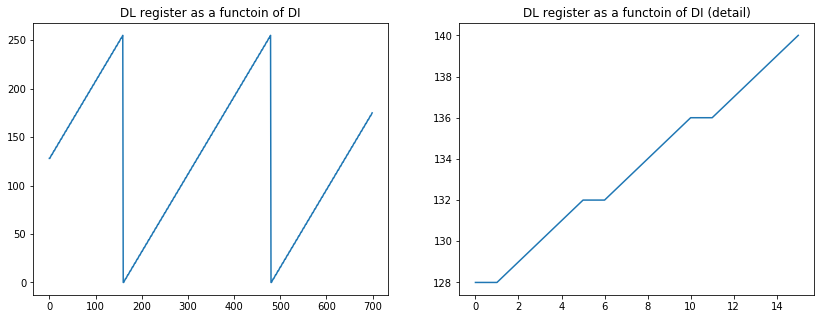

In [4]:
offset = 0
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(result_dl[offset:offset+700])
plt.title("DL register as a functoin of DI")

plt.subplot(1,2,2)
plt.plot(result_dl[offset:offset+16])
plt.title("DL register as a functoin of DI (detail)")

plt.show()

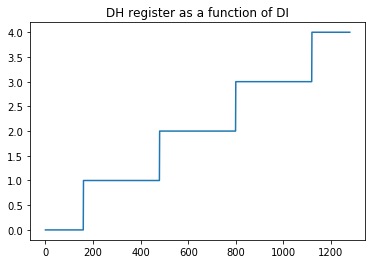

In [5]:
plt.plot(result_dh[offset:offset+640*2])
plt.title("DH register as a function of DI")
plt.show()

So we see the following important properties:

1. Both functions have a period of **320** which is the width of the screen.
2. In the case of `DH` we see that its an increasing function which basically adds 1 after 320 bytes. So, in effect this is basically the *y* coordinate of the pixel at `DI`.
3. In the case of `DL` we see its a sawtooth with period 320. The values go from 0 to 255. Since there are only 256 possible values and the function reaches its maximum when `DI` is 320 then some values must repeat. If you look closely this can be seen. You can think of this as the *x* coordinate except that instead of going up to 319 it goes up to 255.

After HellMood published his article this is what he calls the ["Rrrola trick"](http://www.sizecoding.org/wiki/General_Coding_Tricks#Obtaining_X_and_Y_without_DIV_.28The_Rrrola_Trick.29). In this way you can get an estimate to *y*,*x* without the need to divide and move the results around which require more bytes

## Board of Chessboards effect

The first efffect that appear in the demo is generated by this code:

```
140 fx2: ; board of chessboards
141     xchg dx,ax
142     sub ax,bp
143     xor al,ah
144     or al,0xDB
145     add al,13h
146 ret
```

If you read the main text you'll learn that the most important thing happening here is the line `xor al,ah`. To explore this let's look at what the `XOR` of two 8 bit numbers will look like.


### Calculating the XOR of two bytes

Lets calculate the table of all possible XOR between two nibbles (4 bit numbers). We can calculate this easily like this:

In [6]:
matrix = []
for row in range(0, 16):
    matrix.append( map(lambda col: (row ^ col), range(0, 16)) )
    
print np.array(matrix)

[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 1  0  3  2  5  4  7  6  9  8 11 10 13 12 15 14]
 [ 2  3  0  1  6  7  4  5 10 11  8  9 14 15 12 13]
 [ 3  2  1  0  7  6  5  4 11 10  9  8 15 14 13 12]
 [ 4  5  6  7  0  1  2  3 12 13 14 15  8  9 10 11]
 [ 5  4  7  6  1  0  3  2 13 12 15 14  9  8 11 10]
 [ 6  7  4  5  2  3  0  1 14 15 12 13 10 11  8  9]
 [ 7  6  5  4  3  2  1  0 15 14 13 12 11 10  9  8]
 [ 8  9 10 11 12 13 14 15  0  1  2  3  4  5  6  7]
 [ 9  8 11 10 13 12 15 14  1  0  3  2  5  4  7  6]
 [10 11  8  9 14 15 12 13  2  3  0  1  6  7  4  5]
 [11 10  9  8 15 14 13 12  3  2  1  0  7  6  5  4]
 [12 13 14 15  8  9 10 11  4  5  6  7  0  1  2  3]
 [13 12 15 14  9  8 11 10  5  4  7  6  1  0  3  2]
 [14 15 12 13 10 11  8  9  6  7  4  5  2  3  0  1]
 [15 14 13 12 11 10  9  8  7  6  5  4  3  2  1  0]]


Each element in this matrix is also a nible so we can look at its binary representation. So, if we print this same matrix but each element has the binary representation we can create 4 new matrices with a `0` or `1` in it corresponding to the first, second, etc bits. Let's look at how this 4 matrices look like:

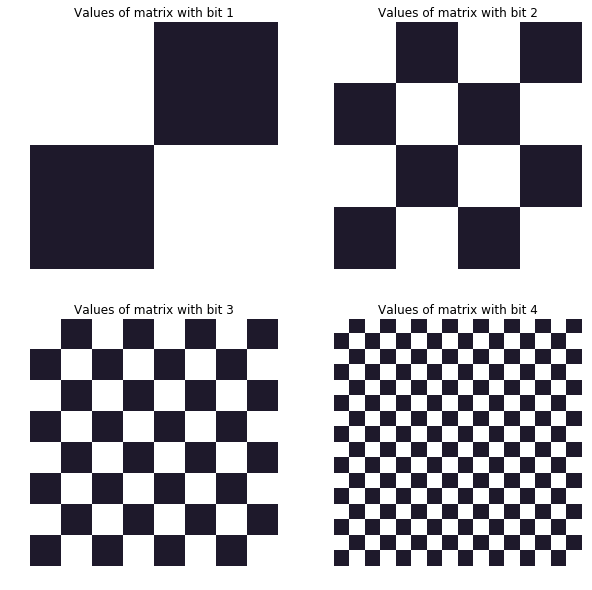

In [7]:
import matplotlib
import copy

cmap = matplotlib.colors.ListedColormap(["white", [.12,.1,.17,1]])

plt.figure(figsize=(10,10))
i = 1
for mask in [0b1000, 0b0100, 0b0010, 0b0001]:
    bits = copy.deepcopy(matrix)
    for row in range(0, 16):
        for col in range(0, 16):
            bits[row][col] = matrix[row][col] & mask

    plt.subplot(2, 2, i)
    plt.imshow(bits, interpolation='none', cmap=cmap, origin='upper' )
    plt.xticks([0,15],['0', '0xf'])
    plt.yticks([0,15],['0', '0xf'])
    plt.axis("off")
    plt.title("Values of matrix with bit %d" % (i))
    i = i + 1

plt.show()


These should start to look familiar. 

### Simulating the effect in Python code

To study a bit more we can write the effect as Python code. I've named all my variables with the name of the corresponding register. You'll notice that often I need to do an AND (&) operation with `0xFF` or `0xFFFF` to make sure the variable doesn't exceed the corresponding register size. I've commented each section of code with the corrresponding part of the orginal assembler effect.

We'll need to read the VGA palette values to use from here on. Let's read the palette froma Git repo I have with a CSV of all the colors and display the first 64 colors:

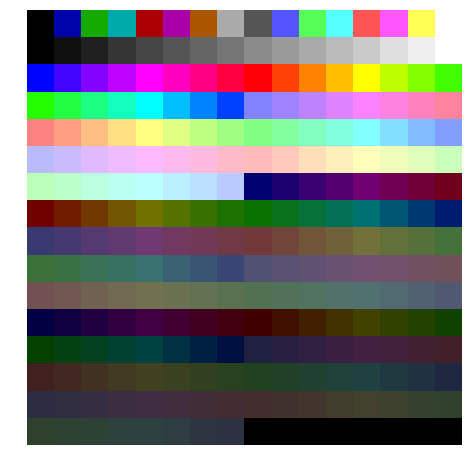

In [8]:
# Read VGA palette: the row number is the index into the array and the first 3 columns are the RGB values
vga_palette = np.genfromtxt('https://gist.githubusercontent.com/cesarmiquel/1780ab6078b9735371d1f10a9d60d233/raw/fb1ab3d46c81f1d43a11838f82cde8df767568d7/vga-palette.csv', delimiter=',')

rgb = []
numrows = 16
for color in range(0, 16 * numrows):
    rgb_pixel = vga_palette[ color ]
    rgb.append(int(rgb_pixel[0]))
    rgb.append(int(rgb_pixel[1]))
    rgb.append(int(rgb_pixel[2]))

rgb_m = np.array(rgb)
rgb_m.shape = (numrows, 16, 3)

plt.figure(figsize=(8,8))
plt.imshow(rgb_m, interpolation='none',origin='upper' )
plt.axis("off")
plt.show()

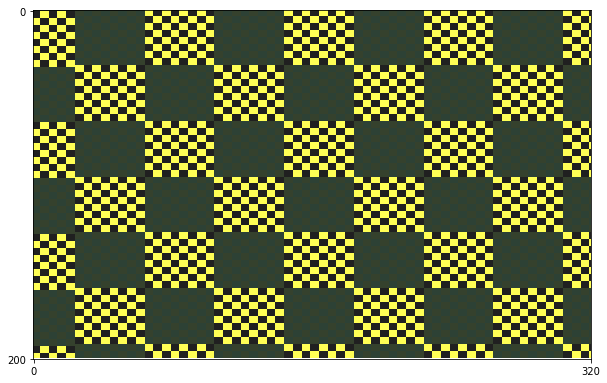

In [39]:
# ---------------------------------------------------------
# This code simulates the effect
# ---------------------------------------------------------
vga_memory = []

bp = 0x13                # you can change bp manually to see what happens

for di in range(0, 0xffff + 1):

    # mov ax, 0xcccd
    # mul di
    m =  di * 0xcccd
    dx = (m & 0xffff0000) >> 16
    dx = dx & 0xffff
    
    # Start of effect code ------------------------------------
    # xchg  ax, dx
    ax = dx
    
    # sub ax, bp
    ax = ax - bp
    
    # xor al, ah     ; calculate x XOR y
    al = 0xff & ax
    ah = (0xff00 & ax) >> 8
    al = al ^ ah 
    
    # or al, 0xDB
    al = al | 0xDB
    
    # add al, 13h
    al = al + 0x13
    al = al & 0xff # convert to 8bit
    
    # End of effect code ---------------------------------------
    
    # Save byte to Video RAM
    vga_memory.append(al)

    
# Plot the contents of VGA RAM with correct colors
bits = np.mat(vga_memory[0:320*200])
bits = bits.reshape(200, 320)

rgb = []
for row in range(0, 200):
    for col in range(0, 320):
        rgb_pixel = vga_palette[ bits[row, col] ]
        rgb.append(int(rgb_pixel[0]))
        rgb.append(int(rgb_pixel[1]))
        rgb.append(int(rgb_pixel[2]))

rgb_m = np.array(rgb)
rgb_m.shape = (200, 320, 3)

plt.figure(figsize=(10,10))
plt.imshow(rgb_m, interpolation='none',origin='upper' )
plt.xticks([0,320],['0', '320'])
plt.yticks([0,200],['0', '200'])
#plt.axis("off")
plt.show()

## Zooming circles effect

```
	mov al,dh		; get Y in AL
	sub al,100		; align Y vertically
	imul al			; AL = Y²
	xchg dx,ax		; Y²/256 in DH, X in AL
	imul al			; AL = X²
	add dh,ah		; DH = (X² + Y²)/256
	mov al,dh		; AL = (X² + Y²)/256
	add ax,bp		; offset color by time
	and al,8+16		; select special rings
``` 

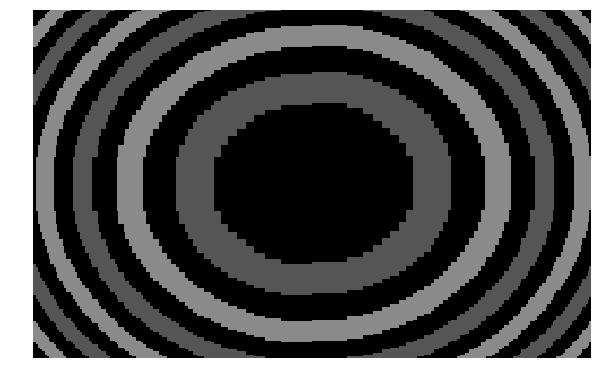

In [40]:
# ---------------------------------------------------------
# This code simulates the effect
# ---------------------------------------------------------

# Simulta imul for two signed bytes as input
def imul8(a, b):
    if a > 0x80:
        a = a - 0x100
    if b > 0x80:
        b = b - 0x100
    result = a * b
    return result & 0xffff

vga_memory = []

bp = 0                # you can change bp manually to see what happens

for di in range(0, 0xffff + 1):
    
    # mov ax, 0xcccd
    # mul di
    m = di * 0xcccd
    dx = (m & 0xffff0000) >> 16
    ax = (m & 0xffff)

    dl = dx & 0xff
    dh = (dx & 0xff00) >> 8
    al = ax & 0xff
    ah = (ax & 0xff00) >> 8
    
    # DEBUG
    #dl = 0
    #dx = dh << 16 + dl
    #dl = 0
    #dh = 100
    
    # Start of effect code ------------------------------------
    # mov al, dh
    al = dh

    # sub al, 100
    al = (al - 100)

    # imul al
    ax = imul8(al, al)
    
    # xchg dx, ax
    temp = dx
    dx = ax
    ax = temp
    
    dl = dx & 0xff
    dh = (dx & 0xff00) >> 8
    al = ax & 0xff
    ah = (ax & 0xff00) >> 8

    # imul al
    ax = imul8(al, al)
    al = ax & 0xff
    ah = (ax & 0xff00) >> 8
    
    # add dh, ah
    dh = (dh + ah) & 0xff
    
    # mov al,dh     ; AL = (X² + Y²)/256
    al = dh
    
    # add ax,bp     ; offset color by time
    ax = (ah << 8) + al + bp
    ax = ax & 0xffff
    al = (ax & 0xff)
    
    # and al,8+16   ; select special rings
    al = al & 0b00011000

    # End of effect code ---------------------------------------
    
    # Save byte to Video RAM
    vga_memory.append(al)
    
# Plot the contents of VGA RAM with correct colors
bits = np.mat(vga_memory[160:320*200+160])
bits = bits.reshape(200, 320)

rgb = []
for row in range(0, 200):
    for col in range(0, 320):
        rgb_pixel = vga_palette[ bits[row, col] ]
        rgb.append(int(rgb_pixel[0]))
        rgb.append(int(rgb_pixel[1]))
        rgb.append(int(rgb_pixel[2]))

rgb_m = np.array(rgb)
rgb_m.shape = (200, 320, 3)

plt.figure(figsize=(10,10))
plt.imshow(rgb_m, interpolation='none',origin='upper' )
plt.xticks([0,320],['0', '320'])
plt.yticks([0,200],['0', '200'])
plt.axis("off")
plt.show()
